# MI2 - ES06: ICA2, Noise and Kurtosis
## The chantastic 4: Elisabeth Kress, Paola Suárez, Jianmeng Wu and Esra Zihni

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import loadmat
from scipy.stats import kurtosis

## 1. Natural Gradient

### a) ICA-learning scheme based on natural gradient

In [2]:
# Helper function for the transformed data
def logistic(y):
    return 1/(1+np.exp(-y))

# Helper fucntion for invertible matrix
def invert(N=3):
    #matrix = np.random.normal(loc=mu, scale=sigma, size=(N, N)) #scipy.stats.ortho_group.rvs
    matrix = np.random.uniform(0, 1, (N, N))
    exception = True
    while exception:
        try:
            np.linalg.inv(matrix)
        except:
            matrix = np.random.uniform(0, 1, (N, N))
        else:
            exception = False
    return matrix

In [3]:
def nat_meng(data, w0, eps=0.5, lamb=0.9):
    """
    Computes natural gradient ascent on an array of mixed sounds in order to obtain the best weight matrix.
    data: an array containing mixed sources.
    w0: initial weight matrix, randomly generated.
    returns
    ws: an array of all the evolution of weights.
    """
    ws = np.zeros((source1.shape[0]+1, 3, 3))
    ws[0] = w0
    for t in np.arange(source1.shape[0]):
        x = data[:, t]
        W = ws[t].copy()
        eps = eps * lamb
        #eps = eps0/(t+1)
        delta = np.identity(3)
        u = np.dot(W, x)
        update = np.dot(delta, W) + np.dot((1- 2*logistic(u)).reshape(3,1), np.dot(u.reshape(1,3), W))
        delta_W = eps * update
        W += delta_W
        ws[t+1] = W
    return ws

### b) ICA on sounds and noise

In [4]:
# Load sounds
source1 = np.loadtxt('sounds/sound1.dat')
source2 = np.loadtxt('sounds/sound2.dat')
original = np.array([source1, source2])

In [5]:
# Create Gaussian noise using mu and sigma from the first two sources 
mu = np.mean(original.mean(axis=1))
sigma = np.mean(original.std(axis=1))
noise_g = np.random.normal(loc=mu, scale=sigma, size=source1.shape)

In [6]:
# Add all sources
original = np.array([source1, source2, noise_g])

In [7]:
# Create an invertible mixing matrix
A = invert()

In [8]:
# Mix the sources
mixed = np.dot(A, original)

In [9]:
# Center the data
mixed_c = np.subtract(mixed.T, mixed.mean(axis=1)).T

In [10]:
# Initialize weights
W0 = invert()

In [11]:
# Run natural gradient
Ws = nat_meng(mixed_c, W0)

In [12]:
# Unmixed
W = Ws[-1]
unmixed = np.dot(W, mixed_c)

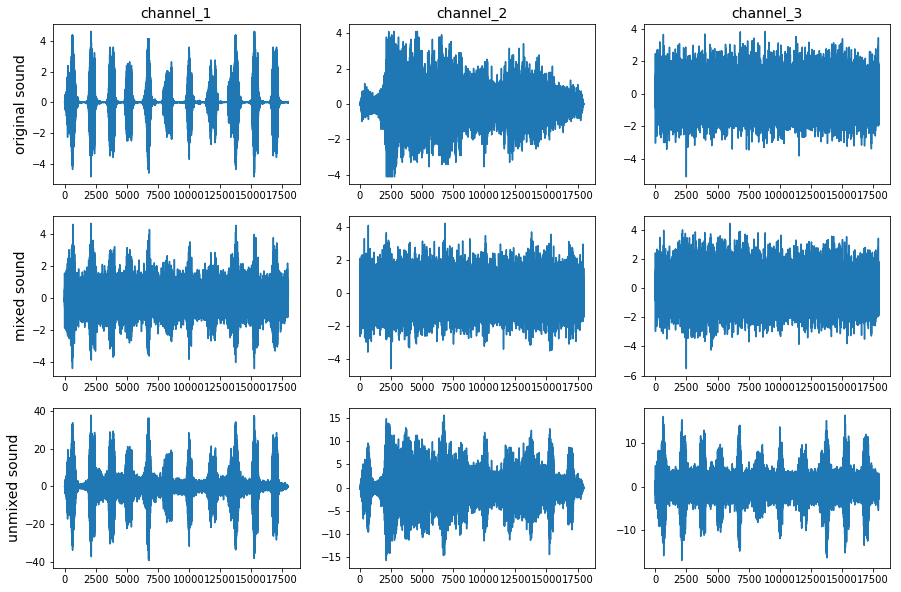

In [13]:
# Plot
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
sounds = [original, mixed, unmixed]
labels1 = ['channel_1', 'channel_2', 'channel_3']
labels2 = ["original", "mixed", "unmixed"]
for i in range(3):
    for j in [0, 1, 2]:
        axes[0,j].set_title("%s" %labels1[j], size=14)
        axes[i,j].plot(sounds[i][j])
        axes[i,0].set_ylabel("%s sound" %labels2[i], size=14)
plt.show()

In [14]:
Audio(unmixed[2], rate=8192)

### c) Repeat with a different noise source

In [15]:
noise_l = np.random.laplace(loc=mu, scale=sigma, size=source1.shape)

In [16]:
# Add all sources
original_l = np.array([source1, source2, noise_l])

In [17]:
# Mix the sources
mixed_l = np.dot(A, original_l)

In [18]:
# Center the data
mixed_cl = np.subtract(mixed_l.T, mixed_l.mean(axis=1)).T

In [19]:
# Run natural gradient
Ws_l = nat_meng(mixed_cl, W0)

In [20]:
# Unmixed
W_l = Ws_l[-1]
unmixed_l = np.dot(W_l, mixed_cl)

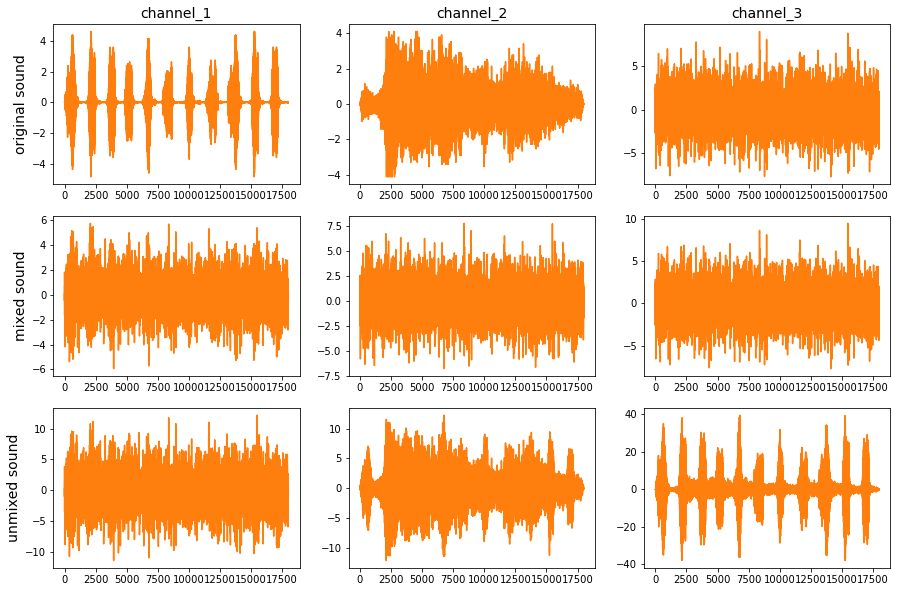

In [21]:
# Plot
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
sounds = [original_l, mixed_l, unmixed_l]
labels1 = ['channel_1', 'channel_2', 'channel_3']
labels2 = ["original", "mixed", "unmixed"]
for i in range(3):
    for j in [0, 1, 2]:
        axes[0,j].set_title("%s" %labels1[j], size=14)
        axes[i,j].plot(sounds[i][j], c="C1")
        axes[i,0].set_ylabel("%s sound" %labels2[i], size=14)
plt.show()

In [27]:
Audio(unmixed_l[2], rate=8192)

## 2. Moments of univariate distributions

In [ ]:
#plt.figure(figsize=(12,10))
#plt.imshow("")
#plt.show()

## 3. Kurtosis of toy data

In [50]:
# Load data
data = loadmat("distrib.mat")
uni = data["uniform"]
nor = data["normal"]
lap = data["laplacian"]

In [51]:
s = np.array([uni, nor, lap])

### a) Apply mixing matrix

In [48]:
A = np.array([[4, 3], [2, 1]])

mix_s = np.array([np.dot(A, s[i]) for i in range(3)])

### b) Center the data

In [116]:
mix_c = np.array([(np.subtract(mix_s[i].T, mix_s.mean(axis=2)[i])).T for i in range(3)])

### c) Decorrelate the data

In [112]:
# PCA
covs = np.array([np.cov(mix_c[i]) for i in range(3)])
ls = np.array([np.linalg.eig(covs[i])[0] for i in range(3)])
es = np.array([np.linalg.eig(covs[i])[1] for i in range(3)])

In [113]:
# Projection
sol = np.array([np.dot(es[i].T, mix_c[i]) for i in range(3)])

### d) Scale the data

In [266]:
# Whiten
mix_w = np.array([np.dot(np.diag(ls[i]**(-1/2)), sol[i]) for i in range(3)])

### e) Rotate and calculate kurtosis

In [171]:
angles = np.linspace(0, 2*np.pi, 101) #np.pi/50)
#angles = np.pi

R = np.array([[np.cos(angles), np.sin(angles)], [-np.sin(angles), np.cos(angles)]]).T

In [184]:
# Rotation
sol_R = np.array([np.array([np.dot(R[j], sol_w[i]) for j in range(101)]) for i in range(3)])

In [222]:
# Kurtosis, k_uni < 0; k_nor ~ 0; k_lap >0
kurts = kurtosis(sol_R, axis=3)

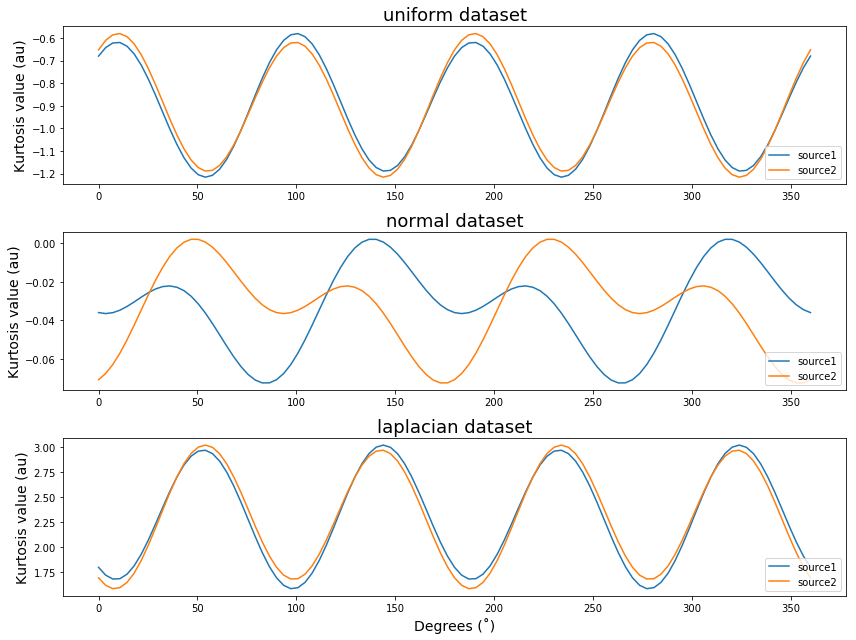

In [264]:
f, axes = plt.subplots(3, 1, figsize=(12,9))
labels = ["uniform", "normal", "laplacian"]
for i in range(3):
    axes[i].plot(np.rad2deg(angles), kurts[i,:,:])
    axes[i].set_title("%s dataset" %labels[i], size=18)
    axes[2].set_xlabel("Degrees (˚)", size=14)
    axes[i].set_ylabel("Kurtosis value (au)", size=14)
    axes[i].legend(["source1", "source2"], loc='lower right')
plt.tight_layout()
plt.show()

### f) Min and max kurtosis

In [303]:
# Extrema of the kurtosis correspond to independent sources if model assumptions are correct
min_k = kurts[:,:,0].argmin(axis=1)
max_k = kurts[:,:,0].argmax(axis=1)

In [306]:
sol_R.shape

(3, 101, 2, 10000)

In [ ]:
# Reduced the dimensions of sol_R to be coherent
sol_R[0,15,0,:], sol_R[]

### Plots

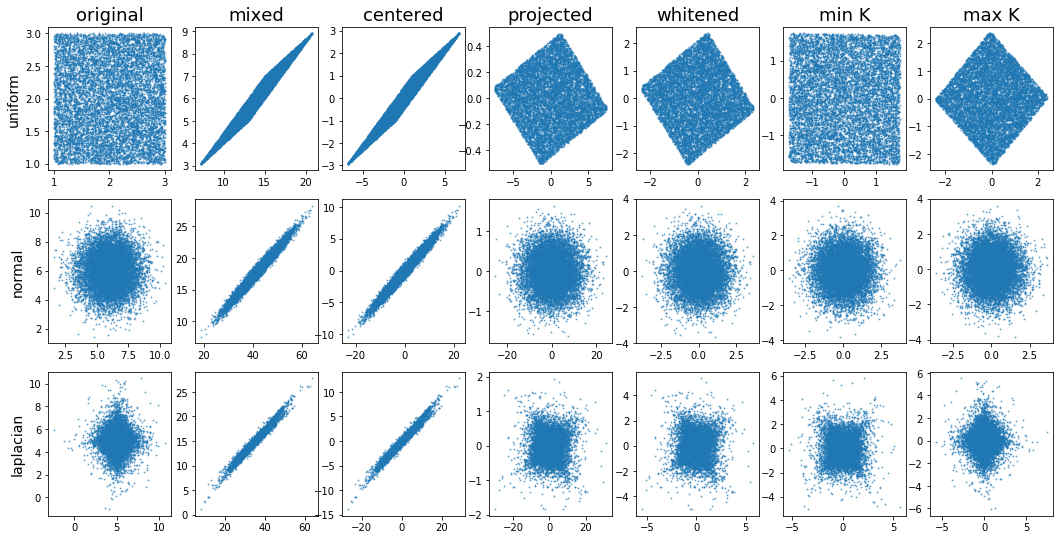

In [310]:
# A lot of plots
f, axes = plt.subplots(3, 7, figsize=(18, 9))
to_plot = [s, mix_s, mix_c, sol, mix_w]
titles = ["original", "mixed", "centered", "projected", "whitened", "min K", "max K"]
labels = ["uniform", "normal", "laplacian"]
for i in range(3):
    for j, d in enumerate(to_plot):
        axes[i,j].scatter(d[i,0,:], d[i,1,:], s=1, alpha=0.5)
        axes[0,j].set_title("%s" %titles[j], size=18)
        axes[i,0].set_ylabel("%s" %labels[i], size=14)
    axes[i,5].scatter(sol_R[i,min_k[i],0,:], sol_R[i,min_k[i],1,:], s=1, alpha=0.5)
    axes[0,5].set_title("%s" %titles[5], size=18)
    axes[i,6].scatter(sol_R[i,max_k[i],0,:], sol_R[i,max_k[i],1,:], s=1, alpha=0.5)
    axes[0,6].set_title("%s" %titles[6], size=18)
plt.show()

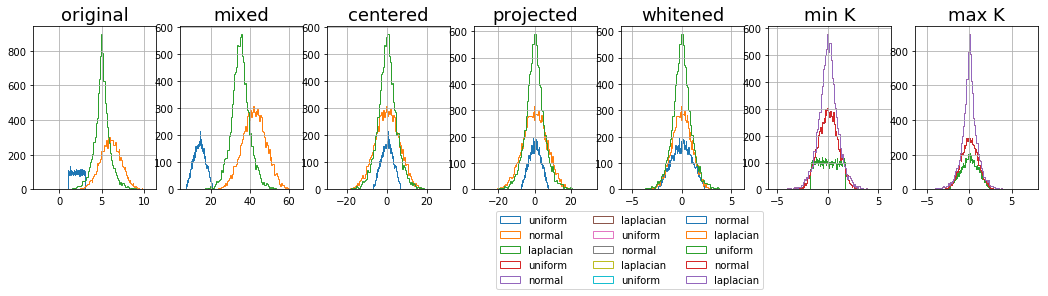

In [313]:
# Plot the probability distribution
f, axes = plt.subplots(1, 7, figsize=(18, 3))
to_plot = [s, mix_s, mix_c, sol, mix_w]
titles = ["original", "mixed", "centered", "projected", "whitened", "min K", "max K"]
labels = ["uniform", "normal", "laplacian"]

for j, d in enumerate(to_plot):
    for i in range(3):
        axes[j].hist(d[i,0,:], bins=100, histtype='step', label=labels[i])
        axes[j].set_title("%s" %titles[j], size=18)
        axes[j].grid()
        
        axes[5].hist(sol_R[i,min_k[i],0,:], bins=100, histtype='step', label=labels[i])
        axes[5].set_title("%s" %titles[5], size=18)
        axes[5].grid()
        axes[6].hist(sol_R[i,max_k[i],0,:], bins=100, histtype='step', label=labels[i])
        axes[6].set_title("%s" %titles[6], size=18)
        axes[6].grid()
        #axes[0,j].set_title("%s" %titles[j], size=18)
        #axes[i,0].set_ylabel("%s" %labels[i], size=14)
plt.legend(ncol=3, bbox_to_anchor=(-1.2,-0.1))
plt.show()

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    axes[i,0].scatter(s[i,0,:], s[i,1,:], s=1, alpha=0.5)
    axes[i,1].scatter(sol_R[i,min_k[i],0,:], sol_R[i,min_k[i],1,:], s=1, alpha=0.5)
    axes[i,2].scatter(sol_R[i,max_k[i],0,:], sol_R[i,max_k[i],1,:], s=1, alpha=0.5)
plt.show()